# Fungi Classification

Dataset - 
Hajati,Farshid, Javier Pineda Sopo,Camilo, Hajati,Farshid, and Gheisari,Soheila. (2023). DeFungi. UCI Machine Learning Repository. https://doi.org/10.48550/arXiv.2109.07322.

link - https://archive.ics.uci.edu/dataset/773/defungi

The dataset contains pre-processed images from fungal infections

We have to classify 6 fungi types using CNNs

| Class | Fungi Type                                    | Count |
|-------|-----------------------------------------------|-------|
| H1    | Tortuous septate hyaline hyphae               | 4,404 |
| H2    | Beaded arthroconidial septate hyaline hyphae  | 2,334 |
| H3    | Groups or mosaics of arthroconidia            |   819 |
| H5    | Septate hyaline hyphae with chlamydioconidia  |   818 |
| H6    | Broad brown hyphae                            |   739 |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder

In [2]:
# Config
n_classes = 5
img_size = 128

device = torch.device('cuda')
device

device(type='cuda')

## Loading Data

In [3]:
data = ImageFolder('data/defungi/', transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5370, 0.5384, 0.5086], [0.0568, 0.0548, 0.0467]),
    transforms.Resize(img_size)
]))

In [4]:
data.classes

['H1', 'H2', 'H3', 'H5', 'H6']

In [5]:
train_data, val_data, test_data = random_split(data, [0.75, 0.15, 0.1])

In [6]:
len(train_data), len(val_data), len(test_data)

(6836, 1367, 911)

In [7]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=512, shuffle=True)
test_loader = DataLoader(test_data, batch_size=512, shuffle=True)

In [8]:
def show_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(labels[i].item())
        plt.axis('off')
    plt.show()

/home/aakash_ks.iitr/miniconda3/envs/py310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


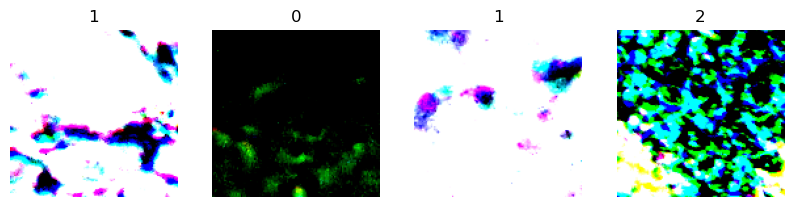

In [9]:
images, labels = next(iter(train_loader))
show_images(images, labels)

In [10]:
images.shape

torch.Size([128, 3, 128, 128])

## Model

In [11]:
class VGG16(nn.Module):
    def __init__(self, n_classes=n_classes):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.LazyLinear(4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, n_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model = VGG16().to(device)

/home/aakash_ks.iitr/miniconda3/envs/py310/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
lr = 1e-4

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [13]:
num_epochs = 100
num_batches = len(train_loader)
val_batches = len(val_loader)
num_batches

54

## Training Model

In [14]:
logger = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    
    train_loss = 0
    train_acc = 0
    for i, (images, labels) in enumerate(train_loader):
        # move images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        output = model(images)
        loss = criterion(output, labels)
        
        # backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = (output.max(1)[1] == labels).sum().item() / len(labels)
        
        train_loss += loss
        train_acc += acc
        
        # logging
        if (i+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{num_batches}, Loss {loss:.4f}, Acc {acc*100:.1f}%')
        
    with torch.no_grad():
        model.eval()
        
        val_loss = 0
        val_acc = 0
        
        logger['train_loss'].append(train_loss.detach().cpu().numpy() / num_batches)
        logger['train_acc'].append(train_acc / num_batches)
        
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            loss = criterion(output, labels)
            
            acc = (output.max(1)[1] == labels).sum().item() / len(labels)

            val_loss += loss
            val_acc += acc
            
        logger['val_loss'].append(val_loss.detach().cpu().numpy() / val_batches)
        logger['val_acc'].append(val_acc / val_batches)
    
    print(f"---- Epoch {epoch+1} : Val Acc {logger['val_acc'][-1]:.3f}, Train Loss {logger['train_loss'][-1]:.4f}, Val Loss {logger['val_loss'][-1]:.4f}")

Epoch 1/100, Step 10/54, Loss 1.0354, Acc 56.2%


Epoch 1/100, Step 20/54, Loss 0.9992, Acc 60.9%


Epoch 1/100, Step 30/54, Loss 0.9665, Acc 60.9%


Epoch 1/100, Step 40/54, Loss 0.9877, Acc 59.4%


Epoch 1/100, Step 50/54, Loss 0.9118, Acc 65.6%


---- Epoch 1 : Val Acc 0.650, Train Loss 1.0243, Val Loss 0.9447


Epoch 2/100, Step 10/54, Loss 0.8823, Acc 66.4%


Epoch 2/100, Step 20/54, Loss 0.8593, Acc 66.4%


Epoch 2/100, Step 30/54, Loss 0.8210, Acc 62.5%


Epoch 2/100, Step 40/54, Loss 0.9541, Acc 68.8%


Epoch 2/100, Step 50/54, Loss 0.7921, Acc 68.0%


---- Epoch 2 : Val Acc 0.625, Train Loss 0.8696, Val Loss 0.8635


Epoch 3/100, Step 10/54, Loss 0.8856, Acc 64.8%


Epoch 3/100, Step 20/54, Loss 0.8987, Acc 57.8%


Epoch 3/100, Step 30/54, Loss 0.6668, Acc 71.1%


Epoch 3/100, Step 40/54, Loss 0.8377, Acc 68.8%


Epoch 3/100, Step 50/54, Loss 1.0750, Acc 59.4%


---- Epoch 3 : Val Acc 0.653, Train Loss 0.8200, Val Loss 0.8288


Epoch 4/100, Step 10/54, Loss 0.7462, Acc 73.4%


Epoch 4/100, Step 20/54, Loss 0.8082, Acc 68.0%


Epoch 4/100, Step 30/54, Loss 0.7689, Acc 71.9%


Epoch 4/100, Step 40/54, Loss 0.7877, Acc 68.8%


Epoch 4/100, Step 50/54, Loss 0.9069, Acc 60.2%


---- Epoch 4 : Val Acc 0.695, Train Loss 0.7754, Val Loss 0.7644


Epoch 5/100, Step 10/54, Loss 0.7755, Acc 73.4%


Epoch 5/100, Step 20/54, Loss 0.6799, Acc 73.4%


Epoch 5/100, Step 30/54, Loss 0.6320, Acc 71.1%


Epoch 5/100, Step 40/54, Loss 0.6034, Acc 78.1%


Epoch 5/100, Step 50/54, Loss 0.8364, Acc 64.8%


---- Epoch 5 : Val Acc 0.706, Train Loss 0.7403, Val Loss 0.6958


Epoch 6/100, Step 10/54, Loss 0.5814, Acc 75.8%


Epoch 6/100, Step 20/54, Loss 0.7833, Acc 68.0%


Epoch 6/100, Step 30/54, Loss 0.6850, Acc 71.9%


Epoch 6/100, Step 40/54, Loss 0.7420, Acc 71.9%


Epoch 6/100, Step 50/54, Loss 0.6726, Acc 78.9%


---- Epoch 6 : Val Acc 0.731, Train Loss 0.7206, Val Loss 0.6850


Epoch 7/100, Step 10/54, Loss 0.6868, Acc 70.3%


Epoch 7/100, Step 20/54, Loss 0.9317, Acc 68.0%


Epoch 7/100, Step 30/54, Loss 0.6838, Acc 70.3%


Epoch 7/100, Step 40/54, Loss 0.5595, Acc 77.3%


Epoch 7/100, Step 50/54, Loss 0.7279, Acc 71.1%


---- Epoch 7 : Val Acc 0.757, Train Loss 0.7032, Val Loss 0.6220


Epoch 8/100, Step 10/54, Loss 0.8720, Acc 63.3%


Epoch 8/100, Step 20/54, Loss 0.5985, Acc 82.8%


Epoch 8/100, Step 30/54, Loss 0.7390, Acc 71.1%


Epoch 8/100, Step 40/54, Loss 0.6531, Acc 74.2%


Epoch 8/100, Step 50/54, Loss 0.6605, Acc 71.9%


---- Epoch 8 : Val Acc 0.687, Train Loss 0.6791, Val Loss 0.7380


Epoch 9/100, Step 10/54, Loss 0.7276, Acc 71.1%


Epoch 9/100, Step 20/54, Loss 0.7338, Acc 70.3%


Epoch 9/100, Step 30/54, Loss 0.6327, Acc 71.9%


Epoch 9/100, Step 40/54, Loss 0.5214, Acc 78.9%


Epoch 9/100, Step 50/54, Loss 0.7923, Acc 68.0%


---- Epoch 9 : Val Acc 0.730, Train Loss 0.6514, Val Loss 0.6696


Epoch 10/100, Step 10/54, Loss 0.6523, Acc 73.4%


Epoch 10/100, Step 20/54, Loss 0.6516, Acc 75.8%


Epoch 10/100, Step 30/54, Loss 0.6301, Acc 78.9%


Epoch 10/100, Step 40/54, Loss 0.5821, Acc 78.9%


Epoch 10/100, Step 50/54, Loss 0.6004, Acc 79.7%


---- Epoch 10 : Val Acc 0.755, Train Loss 0.6530, Val Loss 0.6020


Epoch 11/100, Step 10/54, Loss 0.5965, Acc 73.4%


Epoch 11/100, Step 20/54, Loss 0.6716, Acc 71.9%


Epoch 11/100, Step 30/54, Loss 0.6283, Acc 72.7%


Epoch 11/100, Step 40/54, Loss 0.5463, Acc 77.3%


Epoch 11/100, Step 50/54, Loss 0.7433, Acc 71.1%


---- Epoch 11 : Val Acc 0.737, Train Loss 0.6200, Val Loss 0.6313


Epoch 12/100, Step 10/54, Loss 0.6476, Acc 77.3%


Epoch 12/100, Step 20/54, Loss 0.5215, Acc 78.1%


Epoch 12/100, Step 30/54, Loss 0.6144, Acc 76.6%


Epoch 12/100, Step 40/54, Loss 0.5257, Acc 78.1%


Epoch 12/100, Step 50/54, Loss 0.5547, Acc 79.7%


---- Epoch 12 : Val Acc 0.759, Train Loss 0.6089, Val Loss 0.5839


Epoch 13/100, Step 10/54, Loss 0.5862, Acc 75.8%


Epoch 13/100, Step 20/54, Loss 0.6488, Acc 74.2%


Epoch 13/100, Step 30/54, Loss 0.4841, Acc 80.5%


Epoch 13/100, Step 40/54, Loss 0.6091, Acc 75.8%


Epoch 13/100, Step 50/54, Loss 0.5526, Acc 75.8%


---- Epoch 13 : Val Acc 0.758, Train Loss 0.6013, Val Loss 0.5912


Epoch 14/100, Step 10/54, Loss 0.6328, Acc 72.7%


Epoch 14/100, Step 20/54, Loss 0.5964, Acc 80.5%


Epoch 14/100, Step 30/54, Loss 0.4993, Acc 80.5%


Epoch 14/100, Step 40/54, Loss 0.6263, Acc 76.6%


Epoch 14/100, Step 50/54, Loss 0.5374, Acc 74.2%


---- Epoch 14 : Val Acc 0.760, Train Loss 0.5806, Val Loss 0.5856


Epoch 15/100, Step 10/54, Loss 0.6024, Acc 74.2%


Epoch 15/100, Step 20/54, Loss 0.6199, Acc 71.1%


Epoch 15/100, Step 30/54, Loss 0.5664, Acc 77.3%


Epoch 15/100, Step 40/54, Loss 0.5616, Acc 76.6%


Epoch 15/100, Step 50/54, Loss 0.5427, Acc 75.8%


---- Epoch 15 : Val Acc 0.772, Train Loss 0.5576, Val Loss 0.5390


Epoch 16/100, Step 10/54, Loss 0.4620, Acc 83.6%


Epoch 16/100, Step 20/54, Loss 0.5354, Acc 74.2%


Epoch 16/100, Step 30/54, Loss 0.6136, Acc 77.3%


Epoch 16/100, Step 40/54, Loss 0.5616, Acc 81.2%


Epoch 16/100, Step 50/54, Loss 0.4644, Acc 81.2%


---- Epoch 16 : Val Acc 0.779, Train Loss 0.5714, Val Loss 0.5346


Epoch 17/100, Step 10/54, Loss 0.5714, Acc 78.9%


Epoch 17/100, Step 20/54, Loss 0.4524, Acc 82.0%


Epoch 17/100, Step 30/54, Loss 0.5360, Acc 74.2%


Epoch 17/100, Step 40/54, Loss 0.6975, Acc 71.9%


Epoch 17/100, Step 50/54, Loss 0.5305, Acc 75.8%


---- Epoch 17 : Val Acc 0.792, Train Loss 0.5334, Val Loss 0.5258


Epoch 18/100, Step 10/54, Loss 0.4921, Acc 79.7%


Epoch 18/100, Step 20/54, Loss 0.6715, Acc 74.2%


Epoch 18/100, Step 30/54, Loss 0.4975, Acc 78.9%


Epoch 18/100, Step 40/54, Loss 0.4413, Acc 82.8%


Epoch 18/100, Step 50/54, Loss 0.5253, Acc 81.2%


---- Epoch 18 : Val Acc 0.726, Train Loss 0.5184, Val Loss 0.6892


Epoch 19/100, Step 10/54, Loss 0.3813, Acc 82.8%


Epoch 19/100, Step 20/54, Loss 0.4427, Acc 85.9%


Epoch 19/100, Step 30/54, Loss 0.5742, Acc 75.8%


Epoch 19/100, Step 40/54, Loss 0.4879, Acc 83.6%


Epoch 19/100, Step 50/54, Loss 0.5842, Acc 75.8%


---- Epoch 19 : Val Acc 0.796, Train Loss 0.5175, Val Loss 0.5168


Epoch 20/100, Step 10/54, Loss 0.4248, Acc 80.5%


Epoch 20/100, Step 20/54, Loss 0.4874, Acc 80.5%


Epoch 20/100, Step 30/54, Loss 0.5857, Acc 78.9%


Epoch 20/100, Step 40/54, Loss 0.6770, Acc 74.2%


Epoch 20/100, Step 50/54, Loss 0.5460, Acc 78.1%


---- Epoch 20 : Val Acc 0.795, Train Loss 0.5141, Val Loss 0.5144


Epoch 21/100, Step 10/54, Loss 0.4232, Acc 85.2%


Epoch 21/100, Step 20/54, Loss 0.4874, Acc 82.0%


Epoch 21/100, Step 30/54, Loss 0.4080, Acc 83.6%


Epoch 21/100, Step 40/54, Loss 0.5453, Acc 79.7%


Epoch 21/100, Step 50/54, Loss 0.4208, Acc 85.2%


---- Epoch 21 : Val Acc 0.804, Train Loss 0.4969, Val Loss 0.5057


Epoch 22/100, Step 10/54, Loss 0.6450, Acc 75.0%


Epoch 22/100, Step 20/54, Loss 0.3787, Acc 84.4%


Epoch 22/100, Step 30/54, Loss 0.6260, Acc 76.6%


Epoch 22/100, Step 40/54, Loss 0.5617, Acc 83.6%


Epoch 22/100, Step 50/54, Loss 0.3453, Acc 91.4%


---- Epoch 22 : Val Acc 0.827, Train Loss 0.4897, Val Loss 0.4459


Epoch 23/100, Step 10/54, Loss 0.4530, Acc 81.2%


Epoch 23/100, Step 20/54, Loss 0.5256, Acc 78.1%


Epoch 23/100, Step 30/54, Loss 0.6149, Acc 75.0%


Epoch 23/100, Step 40/54, Loss 0.6444, Acc 78.1%


Epoch 23/100, Step 50/54, Loss 0.5927, Acc 77.3%


---- Epoch 23 : Val Acc 0.750, Train Loss 0.4889, Val Loss 0.6557


Epoch 24/100, Step 10/54, Loss 0.6635, Acc 71.9%


Epoch 24/100, Step 20/54, Loss 0.4464, Acc 82.0%


Epoch 24/100, Step 30/54, Loss 0.4300, Acc 80.5%


Epoch 24/100, Step 40/54, Loss 0.4287, Acc 84.4%


Epoch 24/100, Step 50/54, Loss 0.4834, Acc 82.8%


---- Epoch 24 : Val Acc 0.783, Train Loss 0.4664, Val Loss 0.5688


Epoch 25/100, Step 10/54, Loss 0.3647, Acc 84.4%


Epoch 25/100, Step 20/54, Loss 0.4636, Acc 81.2%


Epoch 25/100, Step 30/54, Loss 0.6520, Acc 79.7%


Epoch 25/100, Step 40/54, Loss 0.3559, Acc 85.2%


Epoch 25/100, Step 50/54, Loss 0.4876, Acc 81.2%


---- Epoch 25 : Val Acc 0.817, Train Loss 0.4466, Val Loss 0.4623


Epoch 26/100, Step 10/54, Loss 0.4331, Acc 80.5%


Epoch 26/100, Step 20/54, Loss 0.3667, Acc 89.1%


Epoch 26/100, Step 30/54, Loss 0.4420, Acc 82.8%


Epoch 26/100, Step 40/54, Loss 0.4441, Acc 82.0%


Epoch 26/100, Step 50/54, Loss 0.4528, Acc 82.8%


---- Epoch 26 : Val Acc 0.816, Train Loss 0.4281, Val Loss 0.4400


Epoch 27/100, Step 10/54, Loss 0.4117, Acc 82.0%


Epoch 27/100, Step 20/54, Loss 0.4779, Acc 75.8%


Epoch 27/100, Step 30/54, Loss 0.5161, Acc 82.0%


Epoch 27/100, Step 40/54, Loss 0.3405, Acc 90.6%


Epoch 27/100, Step 50/54, Loss 0.3583, Acc 89.1%


---- Epoch 27 : Val Acc 0.835, Train Loss 0.4583, Val Loss 0.4393


Epoch 28/100, Step 10/54, Loss 0.4343, Acc 85.2%


Epoch 28/100, Step 20/54, Loss 0.4313, Acc 85.2%


Epoch 28/100, Step 30/54, Loss 0.4506, Acc 80.5%


Epoch 28/100, Step 40/54, Loss 0.4926, Acc 82.8%


Epoch 28/100, Step 50/54, Loss 0.3747, Acc 84.4%


---- Epoch 28 : Val Acc 0.814, Train Loss 0.4118, Val Loss 0.4983


Epoch 29/100, Step 10/54, Loss 0.4706, Acc 82.8%


Epoch 29/100, Step 20/54, Loss 0.3058, Acc 89.8%


Epoch 29/100, Step 30/54, Loss 0.4035, Acc 82.8%


Epoch 29/100, Step 40/54, Loss 0.4988, Acc 79.7%


Epoch 29/100, Step 50/54, Loss 0.5209, Acc 79.7%


---- Epoch 29 : Val Acc 0.825, Train Loss 0.4041, Val Loss 0.4464


Epoch 30/100, Step 10/54, Loss 0.3364, Acc 90.6%


Epoch 30/100, Step 20/54, Loss 0.3026, Acc 89.8%


Epoch 30/100, Step 30/54, Loss 0.4073, Acc 82.8%


Epoch 30/100, Step 40/54, Loss 0.2876, Acc 88.3%


Epoch 30/100, Step 50/54, Loss 0.5680, Acc 82.0%


---- Epoch 30 : Val Acc 0.804, Train Loss 0.4017, Val Loss 0.5024


Epoch 31/100, Step 10/54, Loss 0.3814, Acc 85.2%


Epoch 31/100, Step 20/54, Loss 0.3123, Acc 87.5%


Epoch 31/100, Step 30/54, Loss 0.3244, Acc 85.2%


Epoch 31/100, Step 40/54, Loss 0.4235, Acc 88.3%


Epoch 31/100, Step 50/54, Loss 0.3743, Acc 82.8%


---- Epoch 31 : Val Acc 0.819, Train Loss 0.3955, Val Loss 0.4532


Epoch 32/100, Step 10/54, Loss 0.4137, Acc 89.8%


Epoch 32/100, Step 20/54, Loss 0.3197, Acc 89.1%


Epoch 32/100, Step 30/54, Loss 0.3732, Acc 84.4%


Epoch 32/100, Step 40/54, Loss 0.4501, Acc 80.5%


Epoch 32/100, Step 50/54, Loss 0.4024, Acc 86.7%


---- Epoch 32 : Val Acc 0.855, Train Loss 0.4069, Val Loss 0.3862


Epoch 33/100, Step 10/54, Loss 0.3707, Acc 85.9%


Epoch 33/100, Step 20/54, Loss 0.4452, Acc 84.4%


Epoch 33/100, Step 30/54, Loss 0.4348, Acc 83.6%


Epoch 33/100, Step 40/54, Loss 0.3374, Acc 82.8%


Epoch 33/100, Step 50/54, Loss 0.4661, Acc 87.5%


---- Epoch 33 : Val Acc 0.855, Train Loss 0.3935, Val Loss 0.4056


Epoch 34/100, Step 10/54, Loss 0.2637, Acc 89.1%


Epoch 34/100, Step 20/54, Loss 0.3608, Acc 87.5%


Epoch 34/100, Step 30/54, Loss 0.3292, Acc 88.3%


Epoch 34/100, Step 40/54, Loss 0.3405, Acc 85.9%


Epoch 34/100, Step 50/54, Loss 0.3390, Acc 85.2%


---- Epoch 34 : Val Acc 0.802, Train Loss 0.3814, Val Loss 0.5277


Epoch 35/100, Step 10/54, Loss 0.4791, Acc 80.5%


Epoch 35/100, Step 20/54, Loss 0.3255, Acc 86.7%


Epoch 35/100, Step 30/54, Loss 0.3975, Acc 85.2%


Epoch 35/100, Step 40/54, Loss 0.3914, Acc 82.0%


Epoch 35/100, Step 50/54, Loss 0.3821, Acc 86.7%


---- Epoch 35 : Val Acc 0.844, Train Loss 0.3866, Val Loss 0.4361


Epoch 36/100, Step 10/54, Loss 0.4076, Acc 82.8%


Epoch 36/100, Step 20/54, Loss 0.3163, Acc 85.2%


Epoch 36/100, Step 30/54, Loss 0.2258, Acc 93.8%


Epoch 36/100, Step 40/54, Loss 0.3684, Acc 85.9%


Epoch 36/100, Step 50/54, Loss 0.4666, Acc 85.2%


---- Epoch 36 : Val Acc 0.836, Train Loss 0.3546, Val Loss 0.4173


Epoch 37/100, Step 10/54, Loss 0.3522, Acc 84.4%


Epoch 37/100, Step 20/54, Loss 0.3253, Acc 89.1%


Epoch 37/100, Step 30/54, Loss 0.4359, Acc 85.9%


Epoch 37/100, Step 40/54, Loss 0.3016, Acc 86.7%


Epoch 37/100, Step 50/54, Loss 0.3493, Acc 87.5%


---- Epoch 37 : Val Acc 0.853, Train Loss 0.3310, Val Loss 0.3908


Epoch 38/100, Step 10/54, Loss 0.3493, Acc 87.5%


Epoch 38/100, Step 20/54, Loss 0.2581, Acc 89.1%


Epoch 38/100, Step 30/54, Loss 0.3810, Acc 87.5%


Epoch 38/100, Step 40/54, Loss 0.3833, Acc 85.2%


Epoch 38/100, Step 50/54, Loss 0.2839, Acc 88.3%


---- Epoch 38 : Val Acc 0.856, Train Loss 0.3301, Val Loss 0.3788


Epoch 39/100, Step 10/54, Loss 0.3047, Acc 88.3%


Epoch 39/100, Step 20/54, Loss 0.3532, Acc 89.1%


Epoch 39/100, Step 30/54, Loss 0.3427, Acc 82.0%


Epoch 39/100, Step 40/54, Loss 0.2432, Acc 93.8%


Epoch 39/100, Step 50/54, Loss 0.4722, Acc 85.9%


---- Epoch 39 : Val Acc 0.863, Train Loss 0.3409, Val Loss 0.3739


Epoch 40/100, Step 10/54, Loss 0.2063, Acc 93.8%


Epoch 40/100, Step 20/54, Loss 0.2775, Acc 91.4%


Epoch 40/100, Step 30/54, Loss 0.4106, Acc 81.2%


Epoch 40/100, Step 40/54, Loss 0.3683, Acc 85.2%


Epoch 40/100, Step 50/54, Loss 0.2480, Acc 89.8%


---- Epoch 40 : Val Acc 0.861, Train Loss 0.3073, Val Loss 0.3484


Epoch 41/100, Step 10/54, Loss 0.3145, Acc 87.5%


Epoch 41/100, Step 20/54, Loss 0.1976, Acc 93.8%


Epoch 41/100, Step 30/54, Loss 0.3053, Acc 85.9%


Epoch 41/100, Step 40/54, Loss 0.4950, Acc 85.9%


Epoch 41/100, Step 50/54, Loss 0.2411, Acc 91.4%


---- Epoch 41 : Val Acc 0.848, Train Loss 0.3058, Val Loss 0.4072


Epoch 42/100, Step 10/54, Loss 0.2923, Acc 93.0%


Epoch 42/100, Step 20/54, Loss 0.2924, Acc 86.7%


Epoch 42/100, Step 30/54, Loss 0.3068, Acc 87.5%


Epoch 42/100, Step 40/54, Loss 0.2756, Acc 89.8%


Epoch 42/100, Step 50/54, Loss 0.2648, Acc 91.4%


---- Epoch 42 : Val Acc 0.861, Train Loss 0.3043, Val Loss 0.3629


Epoch 43/100, Step 10/54, Loss 0.2400, Acc 93.0%


Epoch 43/100, Step 20/54, Loss 0.3476, Acc 85.9%


Epoch 43/100, Step 30/54, Loss 0.3775, Acc 88.3%


Epoch 43/100, Step 40/54, Loss 0.2878, Acc 92.2%


Epoch 43/100, Step 50/54, Loss 0.3263, Acc 87.5%


---- Epoch 43 : Val Acc 0.882, Train Loss 0.3045, Val Loss 0.3291


Epoch 44/100, Step 10/54, Loss 0.3053, Acc 85.9%


Epoch 44/100, Step 20/54, Loss 0.2589, Acc 93.8%


Epoch 44/100, Step 30/54, Loss 0.2155, Acc 91.4%


Epoch 44/100, Step 40/54, Loss 0.3395, Acc 85.2%


Epoch 44/100, Step 50/54, Loss 0.2979, Acc 88.3%


---- Epoch 44 : Val Acc 0.855, Train Loss 0.2933, Val Loss 0.3734


Epoch 45/100, Step 10/54, Loss 0.4072, Acc 83.6%


Epoch 45/100, Step 20/54, Loss 0.2484, Acc 91.4%


Epoch 45/100, Step 30/54, Loss 0.2911, Acc 90.6%


Epoch 45/100, Step 40/54, Loss 0.2759, Acc 87.5%


Epoch 45/100, Step 50/54, Loss 0.3354, Acc 87.5%


---- Epoch 45 : Val Acc 0.898, Train Loss 0.2958, Val Loss 0.2898


Epoch 46/100, Step 10/54, Loss 0.2875, Acc 89.1%


Epoch 46/100, Step 20/54, Loss 0.3119, Acc 90.6%


Epoch 46/100, Step 30/54, Loss 0.2085, Acc 92.2%


Epoch 46/100, Step 40/54, Loss 0.3299, Acc 89.1%


Epoch 46/100, Step 50/54, Loss 0.1488, Acc 93.8%


---- Epoch 46 : Val Acc 0.868, Train Loss 0.2927, Val Loss 0.3530


Epoch 47/100, Step 10/54, Loss 0.3234, Acc 85.9%


Epoch 47/100, Step 20/54, Loss 0.3735, Acc 89.1%


Epoch 47/100, Step 30/54, Loss 0.3911, Acc 82.0%


Epoch 47/100, Step 40/54, Loss 0.3033, Acc 88.3%


Epoch 47/100, Step 50/54, Loss 0.2626, Acc 88.3%


---- Epoch 47 : Val Acc 0.881, Train Loss 0.2871, Val Loss 0.3250


Epoch 48/100, Step 10/54, Loss 0.3530, Acc 86.7%


Epoch 48/100, Step 20/54, Loss 0.2641, Acc 91.4%


Epoch 48/100, Step 30/54, Loss 0.2928, Acc 89.1%


Epoch 48/100, Step 40/54, Loss 0.2878, Acc 90.6%


Epoch 48/100, Step 50/54, Loss 0.1855, Acc 94.5%


---- Epoch 48 : Val Acc 0.887, Train Loss 0.2702, Val Loss 0.2798


Epoch 49/100, Step 10/54, Loss 0.2774, Acc 89.1%


Epoch 49/100, Step 20/54, Loss 0.3066, Acc 89.1%


Epoch 49/100, Step 30/54, Loss 0.2007, Acc 92.2%


Epoch 49/100, Step 40/54, Loss 0.3105, Acc 85.2%


Epoch 49/100, Step 50/54, Loss 0.2633, Acc 90.6%


---- Epoch 49 : Val Acc 0.881, Train Loss 0.2666, Val Loss 0.3156


Epoch 50/100, Step 10/54, Loss 0.1970, Acc 94.5%


Epoch 50/100, Step 20/54, Loss 0.3072, Acc 87.5%


Epoch 50/100, Step 30/54, Loss 0.2717, Acc 90.6%


Epoch 50/100, Step 40/54, Loss 0.2805, Acc 88.3%


Epoch 50/100, Step 50/54, Loss 0.2227, Acc 92.2%


---- Epoch 50 : Val Acc 0.875, Train Loss 0.2560, Val Loss 0.3290


Epoch 51/100, Step 10/54, Loss 0.1391, Acc 96.1%


Epoch 51/100, Step 20/54, Loss 0.2329, Acc 93.8%


Epoch 51/100, Step 30/54, Loss 0.1762, Acc 92.2%


Epoch 51/100, Step 40/54, Loss 0.3162, Acc 89.8%


Epoch 51/100, Step 50/54, Loss 0.3765, Acc 84.4%


---- Epoch 51 : Val Acc 0.871, Train Loss 0.2451, Val Loss 0.3224


Epoch 52/100, Step 10/54, Loss 0.2174, Acc 89.8%


Epoch 52/100, Step 20/54, Loss 0.1753, Acc 92.2%


Epoch 52/100, Step 30/54, Loss 0.1785, Acc 93.8%


Epoch 52/100, Step 40/54, Loss 0.2153, Acc 93.0%


Epoch 52/100, Step 50/54, Loss 0.2032, Acc 93.8%


---- Epoch 52 : Val Acc 0.889, Train Loss 0.2448, Val Loss 0.2893


Epoch 53/100, Step 10/54, Loss 0.1821, Acc 96.1%


Epoch 53/100, Step 20/54, Loss 0.2455, Acc 90.6%


Epoch 53/100, Step 30/54, Loss 0.1643, Acc 94.5%


Epoch 53/100, Step 40/54, Loss 0.1906, Acc 92.2%


Epoch 53/100, Step 50/54, Loss 0.1916, Acc 93.0%


---- Epoch 53 : Val Acc 0.890, Train Loss 0.2451, Val Loss 0.3321


Epoch 54/100, Step 10/54, Loss 0.2426, Acc 89.1%


Epoch 54/100, Step 20/54, Loss 0.3026, Acc 90.6%


Epoch 54/100, Step 30/54, Loss 0.3306, Acc 85.2%


Epoch 54/100, Step 40/54, Loss 0.3625, Acc 88.3%


Epoch 54/100, Step 50/54, Loss 0.2515, Acc 91.4%


---- Epoch 54 : Val Acc 0.898, Train Loss 0.2478, Val Loss 0.2753


Epoch 55/100, Step 10/54, Loss 0.1520, Acc 93.0%


Epoch 55/100, Step 20/54, Loss 0.2233, Acc 90.6%


Epoch 55/100, Step 30/54, Loss 0.2147, Acc 93.8%


Epoch 55/100, Step 40/54, Loss 0.1673, Acc 93.8%


Epoch 55/100, Step 50/54, Loss 0.1842, Acc 91.4%


---- Epoch 55 : Val Acc 0.885, Train Loss 0.2337, Val Loss 0.3061


Epoch 56/100, Step 10/54, Loss 0.1538, Acc 93.0%


Epoch 56/100, Step 20/54, Loss 0.1219, Acc 96.1%


Epoch 56/100, Step 30/54, Loss 0.2861, Acc 92.2%


Epoch 56/100, Step 40/54, Loss 0.1600, Acc 94.5%


Epoch 56/100, Step 50/54, Loss 0.2561, Acc 89.8%


---- Epoch 56 : Val Acc 0.892, Train Loss 0.2240, Val Loss 0.2562


Epoch 57/100, Step 10/54, Loss 0.2208, Acc 91.4%


Epoch 57/100, Step 20/54, Loss 0.2486, Acc 91.4%


Epoch 57/100, Step 30/54, Loss 0.3408, Acc 87.5%


Epoch 57/100, Step 40/54, Loss 0.1788, Acc 93.0%


Epoch 57/100, Step 50/54, Loss 0.2668, Acc 86.7%


---- Epoch 57 : Val Acc 0.874, Train Loss 0.2281, Val Loss 0.3573


Epoch 58/100, Step 10/54, Loss 0.2037, Acc 92.2%


Epoch 58/100, Step 20/54, Loss 0.1967, Acc 91.4%


Epoch 58/100, Step 30/54, Loss 0.1602, Acc 95.3%


Epoch 58/100, Step 40/54, Loss 0.1663, Acc 93.0%


Epoch 58/100, Step 50/54, Loss 0.1517, Acc 93.8%


---- Epoch 58 : Val Acc 0.900, Train Loss 0.1963, Val Loss 0.2845


Epoch 59/100, Step 10/54, Loss 0.3224, Acc 89.8%


Epoch 59/100, Step 20/54, Loss 0.2295, Acc 93.8%


Epoch 59/100, Step 30/54, Loss 0.2180, Acc 93.8%


Epoch 59/100, Step 40/54, Loss 0.2434, Acc 89.8%


Epoch 59/100, Step 50/54, Loss 0.2078, Acc 92.2%


---- Epoch 59 : Val Acc 0.876, Train Loss 0.2062, Val Loss 0.3266


Epoch 60/100, Step 10/54, Loss 0.1632, Acc 93.8%


Epoch 60/100, Step 20/54, Loss 0.1548, Acc 94.5%


Epoch 60/100, Step 30/54, Loss 0.3412, Acc 87.5%


Epoch 60/100, Step 40/54, Loss 0.3168, Acc 84.4%


Epoch 60/100, Step 50/54, Loss 0.2823, Acc 89.1%


---- Epoch 60 : Val Acc 0.890, Train Loss 0.2107, Val Loss 0.2946


Epoch 61/100, Step 10/54, Loss 0.1373, Acc 94.5%


Epoch 61/100, Step 20/54, Loss 0.1136, Acc 96.1%


Epoch 61/100, Step 30/54, Loss 0.3142, Acc 89.1%


Epoch 61/100, Step 40/54, Loss 0.1578, Acc 95.3%


Epoch 61/100, Step 50/54, Loss 0.2138, Acc 93.0%


---- Epoch 61 : Val Acc 0.873, Train Loss 0.2002, Val Loss 0.3666


Epoch 62/100, Step 10/54, Loss 0.1953, Acc 92.2%


Epoch 62/100, Step 20/54, Loss 0.2035, Acc 93.0%


Epoch 62/100, Step 30/54, Loss 0.2832, Acc 90.6%


Epoch 62/100, Step 40/54, Loss 0.1204, Acc 96.9%


Epoch 62/100, Step 50/54, Loss 0.2753, Acc 89.8%


---- Epoch 62 : Val Acc 0.870, Train Loss 0.1967, Val Loss 0.3604


Epoch 63/100, Step 10/54, Loss 0.2444, Acc 90.6%


Epoch 63/100, Step 20/54, Loss 0.1662, Acc 93.8%


Epoch 63/100, Step 30/54, Loss 0.2080, Acc 90.6%


Epoch 63/100, Step 40/54, Loss 0.2580, Acc 90.6%


Epoch 63/100, Step 50/54, Loss 0.2486, Acc 89.1%


---- Epoch 63 : Val Acc 0.881, Train Loss 0.2069, Val Loss 0.3388


Epoch 64/100, Step 10/54, Loss 0.1899, Acc 93.0%


Epoch 64/100, Step 20/54, Loss 0.2373, Acc 92.2%


Epoch 64/100, Step 30/54, Loss 0.1662, Acc 93.8%


Epoch 64/100, Step 40/54, Loss 0.1224, Acc 95.3%


Epoch 64/100, Step 50/54, Loss 0.2413, Acc 91.4%


---- Epoch 64 : Val Acc 0.915, Train Loss 0.1948, Val Loss 0.2691


Epoch 65/100, Step 10/54, Loss 0.1745, Acc 90.6%


Epoch 65/100, Step 20/54, Loss 0.3088, Acc 87.5%


Epoch 65/100, Step 30/54, Loss 0.2060, Acc 92.2%


Epoch 65/100, Step 40/54, Loss 0.1602, Acc 93.0%


Epoch 65/100, Step 50/54, Loss 0.3571, Acc 86.7%


---- Epoch 65 : Val Acc 0.908, Train Loss 0.1788, Val Loss 0.2790


Epoch 66/100, Step 10/54, Loss 0.2469, Acc 92.2%


Epoch 66/100, Step 20/54, Loss 0.2529, Acc 89.8%


Epoch 66/100, Step 30/54, Loss 0.1318, Acc 95.3%


Epoch 66/100, Step 40/54, Loss 0.3043, Acc 88.3%


Epoch 66/100, Step 50/54, Loss 0.1455, Acc 96.1%


---- Epoch 66 : Val Acc 0.881, Train Loss 0.1796, Val Loss 0.3319


Epoch 67/100, Step 10/54, Loss 0.1937, Acc 93.8%


Epoch 67/100, Step 20/54, Loss 0.1834, Acc 93.8%


Epoch 67/100, Step 30/54, Loss 0.1403, Acc 96.1%


Epoch 67/100, Step 40/54, Loss 0.2805, Acc 88.3%


Epoch 67/100, Step 50/54, Loss 0.1911, Acc 95.3%


---- Epoch 67 : Val Acc 0.906, Train Loss 0.1702, Val Loss 0.2820


Epoch 68/100, Step 10/54, Loss 0.1434, Acc 93.8%


Epoch 68/100, Step 20/54, Loss 0.0961, Acc 96.9%


Epoch 68/100, Step 30/54, Loss 0.1897, Acc 93.0%


Epoch 68/100, Step 40/54, Loss 0.2500, Acc 89.8%


Epoch 68/100, Step 50/54, Loss 0.1881, Acc 95.3%


---- Epoch 68 : Val Acc 0.902, Train Loss 0.1763, Val Loss 0.2643


Epoch 69/100, Step 10/54, Loss 0.2863, Acc 89.1%


Epoch 69/100, Step 20/54, Loss 0.1125, Acc 96.9%


Epoch 69/100, Step 30/54, Loss 0.1394, Acc 95.3%


Epoch 69/100, Step 40/54, Loss 0.1079, Acc 95.3%


Epoch 69/100, Step 50/54, Loss 0.1906, Acc 91.4%


---- Epoch 69 : Val Acc 0.887, Train Loss 0.1793, Val Loss 0.3167


Epoch 70/100, Step 10/54, Loss 0.1863, Acc 95.3%


Epoch 70/100, Step 20/54, Loss 0.1336, Acc 95.3%


Epoch 70/100, Step 30/54, Loss 0.0862, Acc 96.1%


Epoch 70/100, Step 40/54, Loss 0.1131, Acc 95.3%


Epoch 70/100, Step 50/54, Loss 0.2575, Acc 89.8%


---- Epoch 70 : Val Acc 0.838, Train Loss 0.1489, Val Loss 0.4928


Epoch 71/100, Step 10/54, Loss 0.2127, Acc 90.6%


Epoch 71/100, Step 20/54, Loss 0.1453, Acc 95.3%


Epoch 71/100, Step 30/54, Loss 0.1164, Acc 95.3%


Epoch 71/100, Step 40/54, Loss 0.1138, Acc 96.1%


Epoch 71/100, Step 50/54, Loss 0.1067, Acc 96.9%


---- Epoch 71 : Val Acc 0.920, Train Loss 0.1832, Val Loss 0.2244


Epoch 72/100, Step 10/54, Loss 0.1049, Acc 95.3%


Epoch 72/100, Step 20/54, Loss 0.1326, Acc 94.5%


Epoch 72/100, Step 30/54, Loss 0.1036, Acc 96.9%


Epoch 72/100, Step 40/54, Loss 0.2585, Acc 89.8%


Epoch 72/100, Step 50/54, Loss 0.1784, Acc 95.3%


---- Epoch 72 : Val Acc 0.900, Train Loss 0.1537, Val Loss 0.2983


Epoch 73/100, Step 10/54, Loss 0.2537, Acc 93.0%


Epoch 73/100, Step 20/54, Loss 0.2545, Acc 89.1%


Epoch 73/100, Step 30/54, Loss 0.1365, Acc 95.3%


Epoch 73/100, Step 40/54, Loss 0.2604, Acc 93.0%


Epoch 73/100, Step 50/54, Loss 0.1389, Acc 94.5%


---- Epoch 73 : Val Acc 0.905, Train Loss 0.1723, Val Loss 0.2703


Epoch 74/100, Step 10/54, Loss 0.1659, Acc 93.8%


Epoch 74/100, Step 20/54, Loss 0.1559, Acc 94.5%


Epoch 74/100, Step 30/54, Loss 0.1995, Acc 93.0%


Epoch 74/100, Step 40/54, Loss 0.0873, Acc 96.9%


Epoch 74/100, Step 50/54, Loss 0.1563, Acc 93.8%


---- Epoch 74 : Val Acc 0.902, Train Loss 0.1569, Val Loss 0.2720


Epoch 75/100, Step 10/54, Loss 0.1382, Acc 96.1%


Epoch 75/100, Step 20/54, Loss 0.1096, Acc 94.5%


Epoch 75/100, Step 30/54, Loss 0.1355, Acc 96.1%


Epoch 75/100, Step 40/54, Loss 0.0759, Acc 97.7%


Epoch 75/100, Step 50/54, Loss 0.1838, Acc 94.5%


---- Epoch 75 : Val Acc 0.890, Train Loss 0.1407, Val Loss 0.3499


Epoch 76/100, Step 10/54, Loss 0.2536, Acc 90.6%


Epoch 76/100, Step 20/54, Loss 0.1929, Acc 89.8%


Epoch 76/100, Step 30/54, Loss 0.1401, Acc 94.5%


Epoch 76/100, Step 40/54, Loss 0.1173, Acc 96.1%


Epoch 76/100, Step 50/54, Loss 0.1327, Acc 94.5%


---- Epoch 76 : Val Acc 0.914, Train Loss 0.1632, Val Loss 0.2517


Epoch 77/100, Step 10/54, Loss 0.2896, Acc 89.8%


Epoch 77/100, Step 20/54, Loss 0.2304, Acc 89.1%


Epoch 77/100, Step 30/54, Loss 0.2776, Acc 89.8%


Epoch 77/100, Step 40/54, Loss 0.1557, Acc 96.1%


Epoch 77/100, Step 50/54, Loss 0.2753, Acc 92.2%


---- Epoch 77 : Val Acc 0.871, Train Loss 0.1612, Val Loss 0.4549


Epoch 78/100, Step 10/54, Loss 0.3036, Acc 88.3%


Epoch 78/100, Step 20/54, Loss 0.2697, Acc 92.2%


Epoch 78/100, Step 30/54, Loss 0.1325, Acc 96.1%


Epoch 78/100, Step 40/54, Loss 0.1765, Acc 94.5%


Epoch 78/100, Step 50/54, Loss 0.2845, Acc 89.1%


---- Epoch 78 : Val Acc 0.898, Train Loss 0.1693, Val Loss 0.3202


Epoch 79/100, Step 10/54, Loss 0.1089, Acc 95.3%


Epoch 79/100, Step 20/54, Loss 0.0806, Acc 96.9%


Epoch 79/100, Step 30/54, Loss 0.1076, Acc 95.3%


Epoch 79/100, Step 40/54, Loss 0.0764, Acc 96.9%


Epoch 79/100, Step 50/54, Loss 0.1651, Acc 94.5%


---- Epoch 79 : Val Acc 0.863, Train Loss 0.1436, Val Loss 0.4386


Epoch 80/100, Step 10/54, Loss 0.1410, Acc 96.1%


Epoch 80/100, Step 20/54, Loss 0.1590, Acc 94.5%


Epoch 80/100, Step 30/54, Loss 0.1104, Acc 95.3%


Epoch 80/100, Step 40/54, Loss 0.1421, Acc 94.5%


Epoch 80/100, Step 50/54, Loss 0.1368, Acc 94.5%


---- Epoch 80 : Val Acc 0.905, Train Loss 0.1468, Val Loss 0.2535


Epoch 81/100, Step 10/54, Loss 0.1279, Acc 96.1%


Epoch 81/100, Step 20/54, Loss 0.1282, Acc 96.1%


Epoch 81/100, Step 30/54, Loss 0.1861, Acc 93.8%


Epoch 81/100, Step 40/54, Loss 0.1823, Acc 92.2%


Epoch 81/100, Step 50/54, Loss 0.1191, Acc 96.9%


---- Epoch 81 : Val Acc 0.885, Train Loss 0.1382, Val Loss 0.3906


Epoch 82/100, Step 10/54, Loss 0.0943, Acc 96.1%


Epoch 82/100, Step 20/54, Loss 0.1134, Acc 96.1%


Epoch 82/100, Step 30/54, Loss 0.1169, Acc 95.3%


Epoch 82/100, Step 40/54, Loss 0.1200, Acc 97.7%


Epoch 82/100, Step 50/54, Loss 0.1795, Acc 92.2%


---- Epoch 82 : Val Acc 0.882, Train Loss 0.1369, Val Loss 0.3442


Epoch 83/100, Step 10/54, Loss 0.1531, Acc 94.5%


Epoch 83/100, Step 20/54, Loss 0.1268, Acc 95.3%


Epoch 83/100, Step 30/54, Loss 0.1147, Acc 96.1%


Epoch 83/100, Step 40/54, Loss 0.1811, Acc 93.8%


Epoch 83/100, Step 50/54, Loss 0.1899, Acc 93.8%


---- Epoch 83 : Val Acc 0.900, Train Loss 0.1543, Val Loss 0.3155


Epoch 84/100, Step 10/54, Loss 0.1868, Acc 93.0%


Epoch 84/100, Step 20/54, Loss 0.1670, Acc 94.5%


Epoch 84/100, Step 30/54, Loss 0.1160, Acc 95.3%


Epoch 84/100, Step 40/54, Loss 0.0816, Acc 96.9%


Epoch 84/100, Step 50/54, Loss 0.0687, Acc 98.4%


---- Epoch 84 : Val Acc 0.909, Train Loss 0.1392, Val Loss 0.2573


Epoch 85/100, Step 10/54, Loss 0.1118, Acc 96.9%


Epoch 85/100, Step 20/54, Loss 0.1570, Acc 93.0%


Epoch 85/100, Step 30/54, Loss 0.1261, Acc 93.8%


Epoch 85/100, Step 40/54, Loss 0.0894, Acc 95.3%


Epoch 85/100, Step 50/54, Loss 0.0839, Acc 97.7%


---- Epoch 85 : Val Acc 0.918, Train Loss 0.1282, Val Loss 0.2352


Epoch 86/100, Step 10/54, Loss 0.0862, Acc 96.9%


Epoch 86/100, Step 20/54, Loss 0.0970, Acc 95.3%


Epoch 86/100, Step 30/54, Loss 0.0879, Acc 97.7%


Epoch 86/100, Step 40/54, Loss 0.1018, Acc 97.7%


Epoch 86/100, Step 50/54, Loss 0.0435, Acc 98.4%


---- Epoch 86 : Val Acc 0.901, Train Loss 0.1092, Val Loss 0.3455


Epoch 87/100, Step 10/54, Loss 0.2054, Acc 92.2%


Epoch 87/100, Step 20/54, Loss 0.1889, Acc 93.8%


Epoch 87/100, Step 30/54, Loss 0.1688, Acc 93.8%


Epoch 87/100, Step 40/54, Loss 0.1294, Acc 95.3%


Epoch 87/100, Step 50/54, Loss 0.1287, Acc 95.3%


---- Epoch 87 : Val Acc 0.921, Train Loss 0.1437, Val Loss 0.2390


Epoch 88/100, Step 10/54, Loss 0.0613, Acc 97.7%


Epoch 88/100, Step 20/54, Loss 0.2637, Acc 89.8%


Epoch 88/100, Step 30/54, Loss 0.2496, Acc 90.6%


Epoch 88/100, Step 40/54, Loss 0.1222, Acc 96.1%


Epoch 88/100, Step 50/54, Loss 0.2915, Acc 93.0%


---- Epoch 88 : Val Acc 0.895, Train Loss 0.1252, Val Loss 0.3385


Epoch 89/100, Step 10/54, Loss 0.0519, Acc 100.0%


Epoch 89/100, Step 20/54, Loss 0.1347, Acc 94.5%


Epoch 89/100, Step 30/54, Loss 0.1473, Acc 95.3%


Epoch 89/100, Step 40/54, Loss 0.1419, Acc 96.9%


Epoch 89/100, Step 50/54, Loss 0.0846, Acc 96.9%


---- Epoch 89 : Val Acc 0.925, Train Loss 0.1213, Val Loss 0.2428


Epoch 90/100, Step 10/54, Loss 0.1520, Acc 96.9%


Epoch 90/100, Step 20/54, Loss 0.0807, Acc 96.9%


Epoch 90/100, Step 30/54, Loss 0.1233, Acc 93.8%


Epoch 90/100, Step 40/54, Loss 0.1273, Acc 95.3%


Epoch 90/100, Step 50/54, Loss 0.1525, Acc 96.1%


---- Epoch 90 : Val Acc 0.913, Train Loss 0.1247, Val Loss 0.2593


Epoch 91/100, Step 10/54, Loss 0.0916, Acc 96.9%


Epoch 91/100, Step 20/54, Loss 0.1126, Acc 96.1%


Epoch 91/100, Step 30/54, Loss 0.2162, Acc 89.8%


Epoch 91/100, Step 40/54, Loss 0.0616, Acc 98.4%


Epoch 91/100, Step 50/54, Loss 0.1186, Acc 95.3%


---- Epoch 91 : Val Acc 0.916, Train Loss 0.1035, Val Loss 0.2627


Epoch 92/100, Step 10/54, Loss 0.0833, Acc 96.9%


Epoch 92/100, Step 20/54, Loss 0.2020, Acc 91.4%


Epoch 92/100, Step 30/54, Loss 0.0982, Acc 96.1%


Epoch 92/100, Step 40/54, Loss 0.0767, Acc 96.9%


Epoch 92/100, Step 50/54, Loss 0.0749, Acc 96.9%


---- Epoch 92 : Val Acc 0.929, Train Loss 0.1177, Val Loss 0.2664


Epoch 93/100, Step 10/54, Loss 0.1054, Acc 93.8%


Epoch 93/100, Step 20/54, Loss 0.0568, Acc 99.2%


Epoch 93/100, Step 30/54, Loss 0.1212, Acc 96.1%


Epoch 93/100, Step 40/54, Loss 0.0423, Acc 99.2%


Epoch 93/100, Step 50/54, Loss 0.0655, Acc 97.7%


---- Epoch 93 : Val Acc 0.910, Train Loss 0.1003, Val Loss 0.2825


Epoch 94/100, Step 10/54, Loss 0.1909, Acc 91.4%


Epoch 94/100, Step 20/54, Loss 0.1420, Acc 94.5%


Epoch 94/100, Step 30/54, Loss 0.1841, Acc 93.0%


Epoch 94/100, Step 40/54, Loss 0.1531, Acc 94.5%


Epoch 94/100, Step 50/54, Loss 0.0560, Acc 98.4%


---- Epoch 94 : Val Acc 0.906, Train Loss 0.1037, Val Loss 0.2748


Epoch 95/100, Step 10/54, Loss 0.1631, Acc 94.5%


Epoch 95/100, Step 20/54, Loss 0.1985, Acc 93.8%


Epoch 95/100, Step 30/54, Loss 0.1003, Acc 97.7%


Epoch 95/100, Step 40/54, Loss 0.0844, Acc 96.1%


Epoch 95/100, Step 50/54, Loss 0.1975, Acc 93.8%


---- Epoch 95 : Val Acc 0.929, Train Loss 0.1118, Val Loss 0.2172


Epoch 96/100, Step 10/54, Loss 0.1171, Acc 96.1%


Epoch 96/100, Step 20/54, Loss 0.1482, Acc 96.1%


Epoch 96/100, Step 30/54, Loss 0.1008, Acc 98.4%


Epoch 96/100, Step 40/54, Loss 0.1140, Acc 96.9%


Epoch 96/100, Step 50/54, Loss 0.0713, Acc 97.7%


---- Epoch 96 : Val Acc 0.929, Train Loss 0.0913, Val Loss 0.2377


Epoch 97/100, Step 10/54, Loss 0.2032, Acc 93.8%


Epoch 97/100, Step 20/54, Loss 0.1282, Acc 96.1%


Epoch 97/100, Step 30/54, Loss 0.0988, Acc 95.3%


Epoch 97/100, Step 40/54, Loss 0.0383, Acc 99.2%


Epoch 97/100, Step 50/54, Loss 0.1146, Acc 95.3%


---- Epoch 97 : Val Acc 0.932, Train Loss 0.1183, Val Loss 0.1966


Epoch 98/100, Step 10/54, Loss 0.0985, Acc 96.9%


Epoch 98/100, Step 20/54, Loss 0.0894, Acc 96.1%


Epoch 98/100, Step 30/54, Loss 0.1303, Acc 96.1%


Epoch 98/100, Step 40/54, Loss 0.0843, Acc 96.9%


Epoch 98/100, Step 50/54, Loss 0.0819, Acc 96.1%


---- Epoch 98 : Val Acc 0.901, Train Loss 0.1296, Val Loss 0.2696


Epoch 99/100, Step 10/54, Loss 0.0509, Acc 98.4%


Epoch 99/100, Step 20/54, Loss 0.1260, Acc 94.5%


Epoch 99/100, Step 30/54, Loss 0.0456, Acc 99.2%


Epoch 99/100, Step 40/54, Loss 0.1497, Acc 94.5%


Epoch 99/100, Step 50/54, Loss 0.0781, Acc 96.1%


---- Epoch 99 : Val Acc 0.916, Train Loss 0.0992, Val Loss 0.2797


Epoch 100/100, Step 10/54, Loss 0.1322, Acc 95.3%


Epoch 100/100, Step 20/54, Loss 0.1582, Acc 93.0%


Epoch 100/100, Step 30/54, Loss 0.0827, Acc 98.4%


Epoch 100/100, Step 40/54, Loss 0.1207, Acc 96.1%


Epoch 100/100, Step 50/54, Loss 0.1251, Acc 96.1%


---- Epoch 100 : Val Acc 0.921, Train Loss 0.1238, Val Loss 0.3024


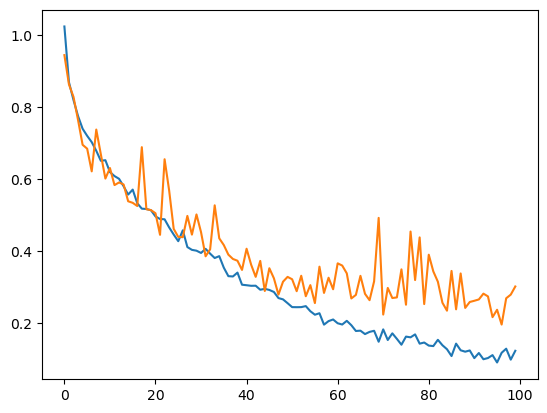

In [15]:
plt.plot(logger['train_loss'])
plt.plot(logger['val_loss'])

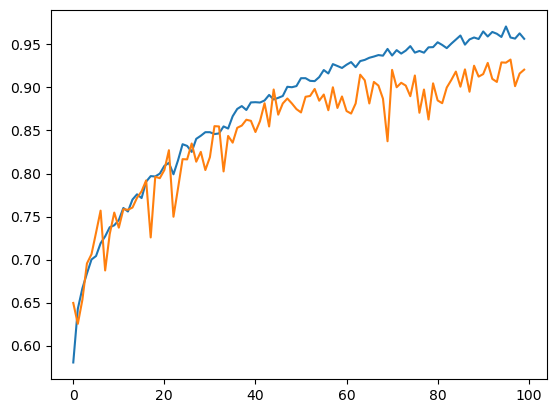

In [16]:
plt.plot(logger['train_acc'])
plt.plot(logger['val_acc'])

In [17]:
with torch.no_grad():
    model.eval()
    
    total_acc = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        output = model(images)
        loss = criterion(output, labels)
        
        acc = (output.max(1)[1] == labels).sum().item() / len(labels)

        total_acc += acc
        
    total_acc /= len(test_loader)
        
    print(f"final accuracy of the model is {total_acc*100:.1f}%")

final accuracy of the model is 89.4%
